In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Import the data and split into train, test and validation
df_raw = pd.read_csv('train.csv')
df_val = pd.read_csv('test.csv')

#Make a copy of the training data
df_training = df_raw.copy(deep = True)

#Make a list of the dataframes for quick cleaning
data_list = [df_training, df_val]

## EDA Part 1

In [3]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The training data set is missing some values from Age, Cabin and Embarked

In [4]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


The validation set is missing some values from Age, Cabin and Fare

In [5]:
df_training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df_val.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


From the describe functions there is evidence of outliers in terms of SibSp and Parch values (max values are several standard deviations from mean) Same with Fare.

# Data Cleaning

In [7]:
#First fill the missing Embarked Data with the mode. Fill the missing Fare data with median
for dataset in data_list:
    
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
    
#Age will filled in by using other predictores that are correlated such as Sex and Class

    age_lookup =  dataset.groupby(['Sex','Pclass']).mean()['Age']
    def fix_age(row):
        if np.isnan(row['Age']):
            return age_lookup[row['Sex']][row['Pclass']]
        else:
            return row['Age']
    dataset['Age'] = dataset.apply(lambda x: fix_age(x),axis=1)
    
#Drop Columns that are no longer need
    
    dataset.drop(['PassengerId','Cabin','Ticket'],axis=1,inplace=True)

## Feature Engineering

Two new features will be engineered, a Family Size (That will then be used to determine if a traveler was alone or had a family with them) and a Title (That can then be broken down into various groups to better attempt to predict survival)

In [16]:
for dataset in data_list:
    
    #Feature Engineering
    
    dataset['Family Size'] = dataset['SibSp'] + dataset['Parch'] + 1 #The 1 is for themselves
    
    dataset['IsAlone'] = 1 #1 Will indicate yes they are alone
    dataset['IsAlone'].loc[dataset['Family Size'] > 1] = 0 #Update IsAlone for people who have family size greater than 1
    
    dataset['Title'] = dataset['Name'].apply(lambda x: x.split(', ')[1].split('.')[0])
    
    #Bin Age and Fare
    
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    
    dataset['FareBin'] = pd.qcut(dataset['Fare'],4) #Using qcut to seperate into quartiles to better caputure high and low fare values

C:\Programming\Anaconda\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Programming\Anaconda\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [23]:
#Clean up the Title so that any title with under 10 people is replaced with 'Other'
def clean_title(dataset, title):
    if dataset['Title'].value_counts()[title] < 10:
        return 'Other'
    else:
        return title
for dataset in data_list:
    dataset['Title'] = dataset.apply(lambda x: clean_title(dataset, x['Title']),axis=1)
    

## Add Dummy Variables

In [25]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
for dataset in data_list:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

#### Helpful trick for later when validating the model is to divide your features into categories such as Original, Calculated and Dummy

In [41]:
Target = ['Survived'] #So now dataset[Target] will return the Survived Column

data_orig = ['Sex','Pclass','Age','Embarked','SibSp','Parch','Fare','Family Size','IsAlone','Title'] #This includes the orginal data and the engineered Family Size and Alone

data_calc = ['Sex_Code','Pclass','Age','Embarked_Code','SibSp','Parch','Fare','Title_Code']

#Now for the binned features

data_bin = ['Sex_Code','Pclass','AgeBin_Code','Embarked_Code', 'IsAlone','FareBin_Code','Title_Code']

#Make dummy variables:

data_training_dummy = pd.get_dummies(df_training[data_orig])

## EDA Part 2

In [50]:
# Check the Survival Rate based on each category:
for feature in data_orig:
    if feature not in ['Fare','Age']:
        print('Survival Corretlation by {}'.format(feature))
        print(df_training[[feature, Target[0]]].groupby(feature,as_index=False).mean())
        print('---------------')

Survival Corretlation by Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------------
Survival Corretlation by Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------------
Survival Corretlation by Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------------
Survival Corretlation by SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------------
Survival Corretlation by Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------------
Survival Corretlation by Family Size
   Family Size  Survived
0            1  0.303538
1            2  0.552795
2            3  0.578431
3            4  0.724138
4            5  0.200000
5            6  0.136364
6            7  0.33333

Make a few graphs to show information about the various features

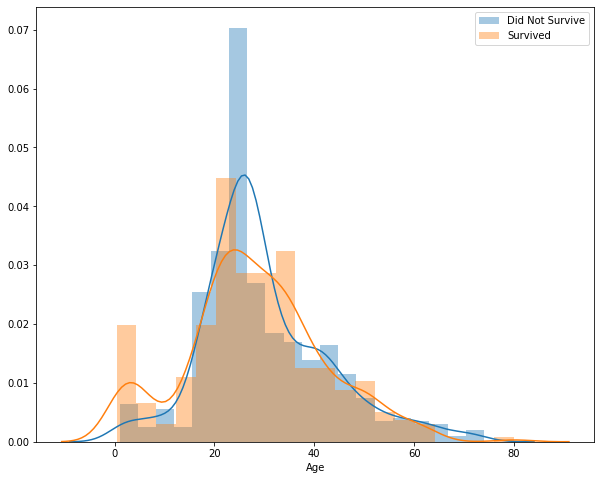

In [57]:
figure = plt.figure(figsize=(10,8))
sns.distplot(df_training.loc[df_training['Survived']==0]['Age'],bins=20)
sns.distplot(df_training.loc[df_training['Survived']==1]['Age'],bins=20)
plt.legend(['Did Not Survive','Survived'])

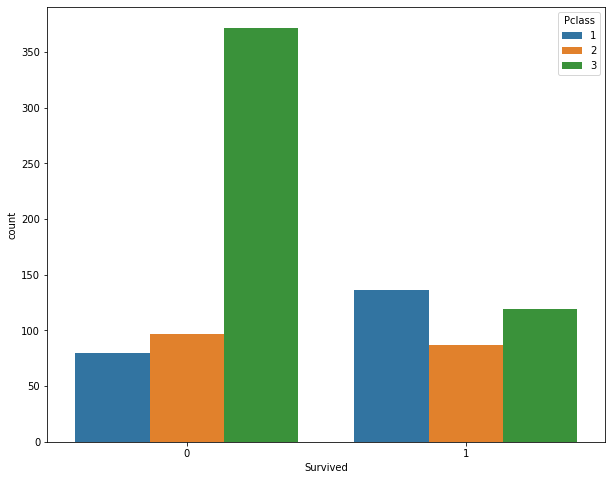

In [59]:
figure = plt.figure(figsize=(10,8))
sns.countplot(x='Survived',data=df_training,hue='Pclass')

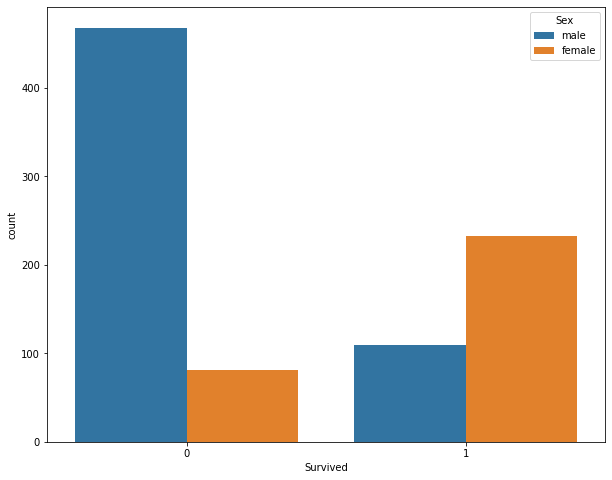

In [60]:
figure = plt.figure(figsize=(10,8))
sns.countplot(x='Survived',data=df_training,hue='Sex')

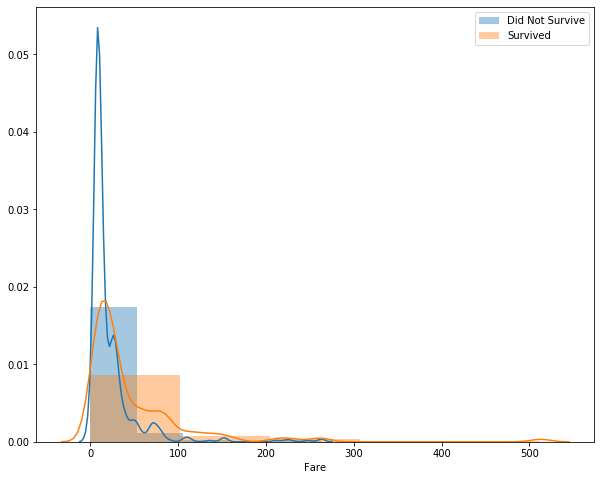

In [63]:
figure = plt.figure(figsize=(10,8))
sns.distplot(df_training.loc[df_training['Survived']==0]['Fare'],bins=5)
sns.distplot(df_training.loc[df_training['Survived']==1]['Fare'],bins=5)
plt.legend(['Did Not Survive','Survived'])

## Split the Data into Training and Test

In [37]:
from sklearn.model_selection import train_test_split

In [43]:
X_train_calc, X_test_calc, y_train_calc, y_test_calc = train_test_split(df_training[data_calc],df_training[Target],random_state=0)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(df_training[data_bin],df_training[Target],random_state=0)

X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(data_training_dummy,df_training[Target],random_state=0)


In [44]:
X_train_dummy.shape

(668, 17)

## Modeling

In [113]:
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate,ShuffleSplit, GridSearchCV

cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

algos =  [BaggingClassifier(), GradientBoostingClassifier(), RandomForestClassifier(),
          LogisticRegression(), RidgeClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(),
         LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), XGBClassifier()]

columns = ['Algorithm Name','Parameters','Train Accuracy Mean','Test Accuracy Mean','Time']

Algo_compare = pd.DataFrame(columns=columns)
predictions = pd.DataFrame()
predictions['True Values'] = list(df_training[Target].values)

#Cycle through the Algorithms and add the values into the Algo_compare DF
row_num = 0
for alg in algos:
    
    name = alg.__class__.__name__
    Algo_compare.loc[row_num, 'Algorithm Name'] = name
    Algo_compare.loc[row_num, 'Parameters'] = str(alg.get_params())
    
    #Perform Cross Validation to determine the accuracy of the training and test sets for each model:
    
    cv_results = cross_validate(alg, df_training[data_bin], df_training[Target].values.ravel(),cv=cv_split,return_train_score=True)
    
    Algo_compare.loc[row_num, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
    Algo_compare.loc[row_num, 'Test Accuracy Mean'] = cv_results['test_score'].mean()
    Algo_compare.loc[row_num, 'Time'] = cv_results['fit_time'].mean()
    
    #Save Predictions:
    
    alg.fit(df_training[data_bin],df_training[Target])
    predictions[name] = alg.predict(df_training[data_bin]) #Returns the training data predictions for each algorithm
    
    row_num += 1


C:\Programming\Anaconda\lib\site-packages\sklearn\ensemble\bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Programming\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Programming\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Programming\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C

In [108]:
Algo_compare

,Algorithm Name,Parameters,Train Accuracy Mean,Test Accuracy Mean,Time
0,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.871536,0.81194,0.00684483
1,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.853933,0.816791,0.0361583
2,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.873596,0.81194,0.00585284
3,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.790262,0.782463,0.00148804
4,RidgeClassifier,"{'alpha': 1.0, 'class_weight': None, 'copy_X':...",0.79382,0.791418,0.0040175
5,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.832772,0.791045,0.00104334
6,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.87603,0.806343,0.00109119
7,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.793633,0.791418,0.00357134
8,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.809925,0.797015,0.00119035
9,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.874157,0.817164,0.0332818


In [111]:
Algo_compare.sort_values(by = ['Test Accuracy Mean'],ascending=False)

,Algorithm Name,Parameters,Train Accuracy Mean,Test Accuracy Mean,Time
9,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.874157,0.817164,0.0332818
1,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.853933,0.816791,0.0361583
0,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.871536,0.81194,0.00684483
2,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.873596,0.81194,0.00585284
6,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.87603,0.806343,0.00109119
8,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.809925,0.797015,0.00119035
4,RidgeClassifier,"{'alpha': 1.0, 'class_weight': None, 'copy_X':...",0.79382,0.791418,0.0040175
7,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.793633,0.791418,0.00357134
5,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.832772,0.791045,0.00104334
3,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.790262,0.782463,0.00148804


Based on the table all of the models perform resonably well but with hyper parameter tunning it might be possible to up these accuracy's even more

In [112]:
#Start with Decision Tree's because they are the most straight forward models

In [114]:
param_grid = {'criterion':['gini','entropy'],'max_depth':[2,4,6,8,10,None],'random_state': [0]}
tune_tree = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, scoring='roc_auc',cv=cv_split)
tune_tree.fit(df_training[data_bin],df_training[Target].values.ravel())

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.3, train_size=0.6),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entr

In [115]:
tune_tree.best_params_

{'criterion': 'gini', 'max_depth': 4, 'random_state': 0}

In [116]:
final_predicts = tune_tree.predict(df_val[data_bin])

In [136]:
ids = pd.read_csv('test.csv')['PassengerId']

In [147]:
sub = pd.DataFrame(ids)

In [149]:
sub['Survived'] = final_predicts

In [154]:
tree_sub = sub.to_csv('3_25_2020_tree_sub.csv',index=False)